# PyMC-Marketing MMM

Relevant imports

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pymc_marketing.mmm import MMM, GeometricAdstock, HillSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, hill_function
from pymc_marketing.prior import Prior
import pymc as pm

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

Loading the data

In [2]:
data = pd.read_csv("input_data_RAW.csv", parse_dates=["date_week"])

In [3]:
config = {'intercept': Prior("Normal", mu=0, sigma=2.0),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=1)),
 'gamma_control': Prior("Normal", mu = 0, sigma=1, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=2, beta=3, dims="channel"),
 'saturation_slope': Prior("DiscreteUniform", lower=1.0, upper=1.0, dims = "channel"),
 'saturation_kappa': Prior("HalfNormal", sigma = 2.0, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2.0, dims="channel")}

In [4]:
mmm = MMM(
    date_column="date_week",
    channel_columns=["x1", "x2", 'x3', 'x4'],
    adstock=GeometricAdstock(l_max=12),
    saturation=HillSaturation(),
    control_columns=['c1', 'c2', 'c3'],
    yearly_seasonality=2,
    model_config = config,
)

## Model Specification

This is a national model with the following specification:

$$
y_{t} = \mu + \sum_{i=0}^{4} \gamma^{[F]}_{i} f_{t,i} 
+ \sum_{i=1}^{N_C} \gamma^{[C]}_{i} z_{t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{i} \text{HillAdstock} \left( \{ x^{[M]}_{t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \kappa^{[M]}_i, slope = 1 \right) + \epsilon_{t}
$$

Where:

- $\mu$ represents the intercept.
- $\sum_{i=0}^{4} \gamma^{[F]}_{i} f_{t,i}$ represents the seasonality/fourier contribution (order 2).
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{i} z_{t,i}$ represents the control contribution.
- $\sum_{i=1}^{N_M} \beta^{[M]}_{i} \text{HillAdstock} \left( \{ x^{[M]}_{t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \kappa^{[M]}_i, slope = 1 \right)$ represents the adstocked saturated media contribution.

**Note** This default configuration has been used:

- $\mu \sim $ Normal(0,2)
- $\beta^{[M]}_i \sim $ HalfNormal(2)
- $\gamma^{[C]} \sim $ HalfNormal(2)
- $\gamma^{[F]} \sim $ Laplace(0,1)
- $\alpha^{[M]} \sim $ Beta(3,3)
- $\kappa^{[M]} \sim $ InverseGamma(2,1)
- $\sigma \sim $ HalfNormal(2) 

In [5]:
X = data.drop("y", axis=1)
y = data["y"]

Prior Predictive

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept, saturation_beta, saturation_kappa, saturation_slope, y, y_sigma]


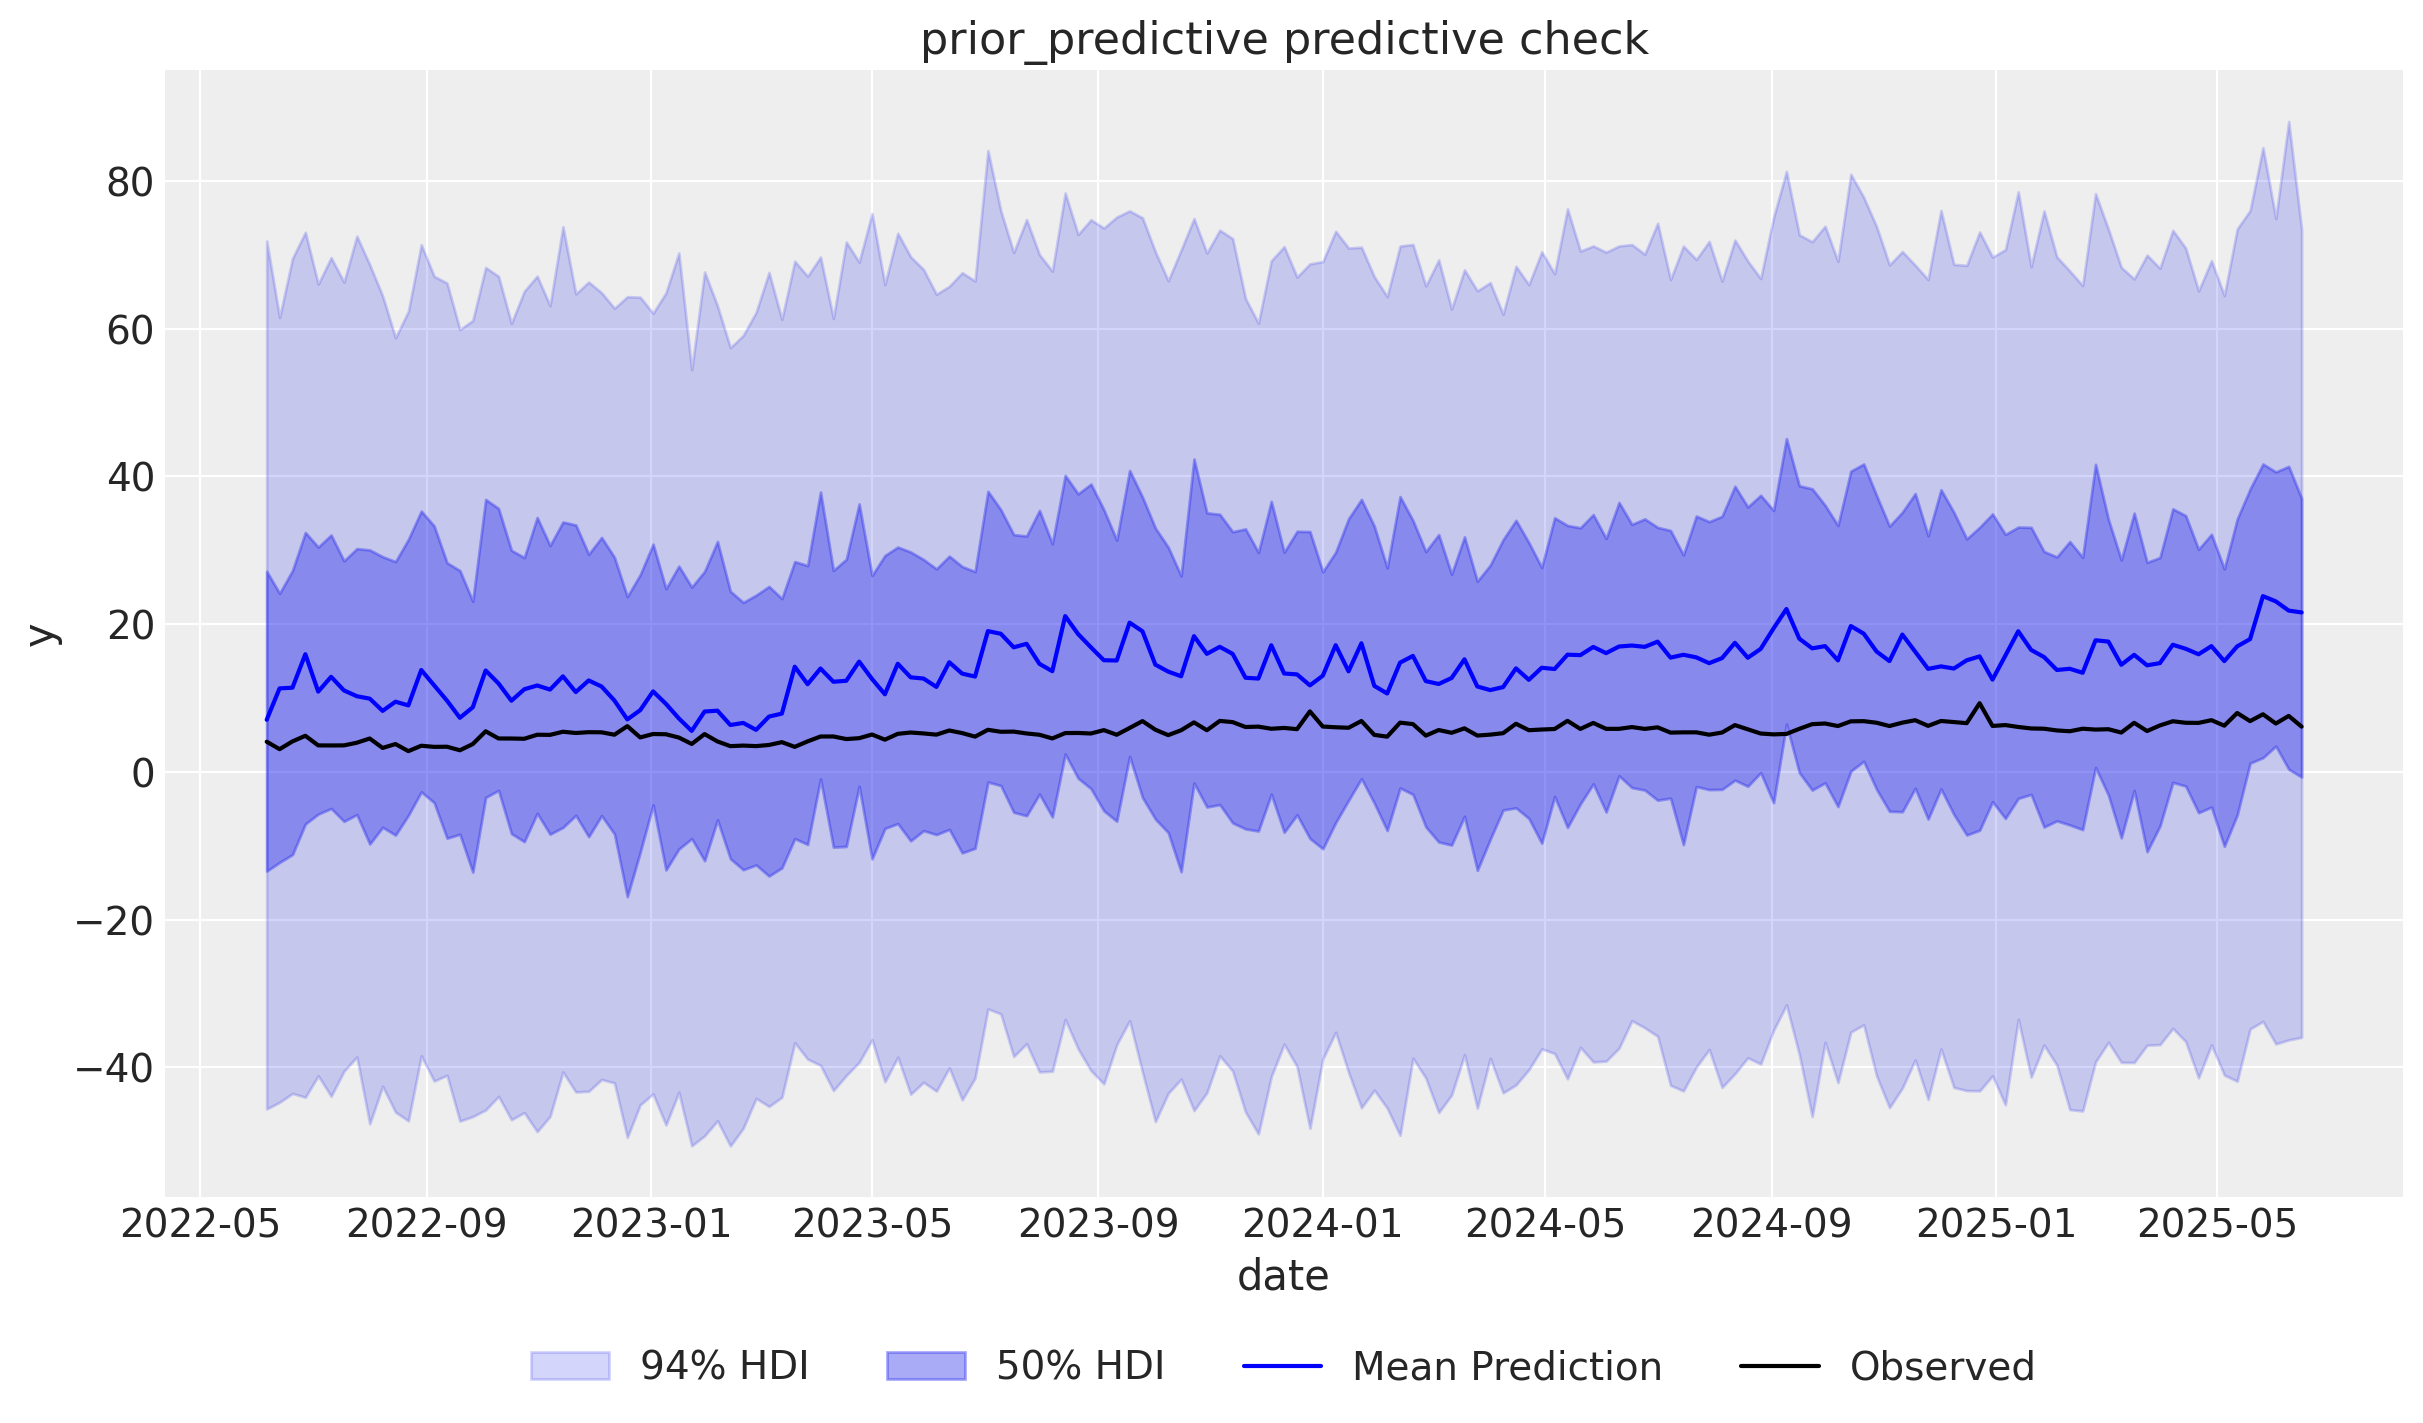

In [6]:
mmm.sample_prior_predictive(X,y, samples = 2000)

fig, ax = plt.subplots()
mmm.plot_prior_predictive(ax=ax, original_scale=True)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4);

In [7]:
mmm.fit(X=X, y=y, chains=4, target_accept=0.90, random_seed=rng)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, adstock_alpha, saturation_kappa, saturation_beta, gamma_control, gamma_fourier, y_sigma]
>Metropolis: [saturation_slope]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

In [8]:
# Number of diverging samples
mmm.idata["sample_stats"]["diverging"].sum().item()

0

In [9]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept", 
        "adstock_alpha", 
        "saturation_kappa", 
        "saturation_beta",
        "saturation_slope",
        "gamma_control", 
        "gamma_fourier", 
        "y_sigma"
    ]
)

/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.246,0.016,0.216,0.277,0.000,0.000,2644.0,2662.0,1.0
adstock_alpha[x1],0.681,0.131,0.411,0.885,0.003,0.002,1923.0,2241.0,1.0
adstock_alpha[x2],0.285,0.061,0.169,0.396,0.001,0.001,2192.0,2495.0,1.0
adstock_alpha[x3],0.436,0.081,0.291,0.590,0.002,0.001,2236.0,2330.0,1.0
adstock_alpha[x4],0.820,0.113,0.624,0.971,0.003,0.002,2131.0,1438.0,1.0
saturation_kappa[x1],2.265,1.154,0.370,4.291,0.022,0.016,2278.0,2271.0,1.0
saturation_kappa[x2],3.423,1.111,1.435,5.397,0.022,0.015,2460.0,2348.0,1.0
saturation_kappa[x3],1.102,0.613,0.318,2.263,0.016,0.012,1527.0,1710.0,1.0
saturation_kappa[x4],2.560,1.276,0.358,4.866,0.024,0.017,2329.0,1495.0,1.0
saturation_beta[x1],0.689,0.296,0.244,1.254,0.006,0.004,1738.0,1983.0,1.0


In [10]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 5MB
Dimensions:  (sample: 4000, date: 159)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2022-06-06 2022-06-13 ... 2025-06-16
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 5MB 4.454 4.219 3.596 ... 6.267 6.61 6.247
Attributes:
    created_at:                 2025-06-19T10:47:50.242778+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.22.0

### Parameter Recovery

Adstock

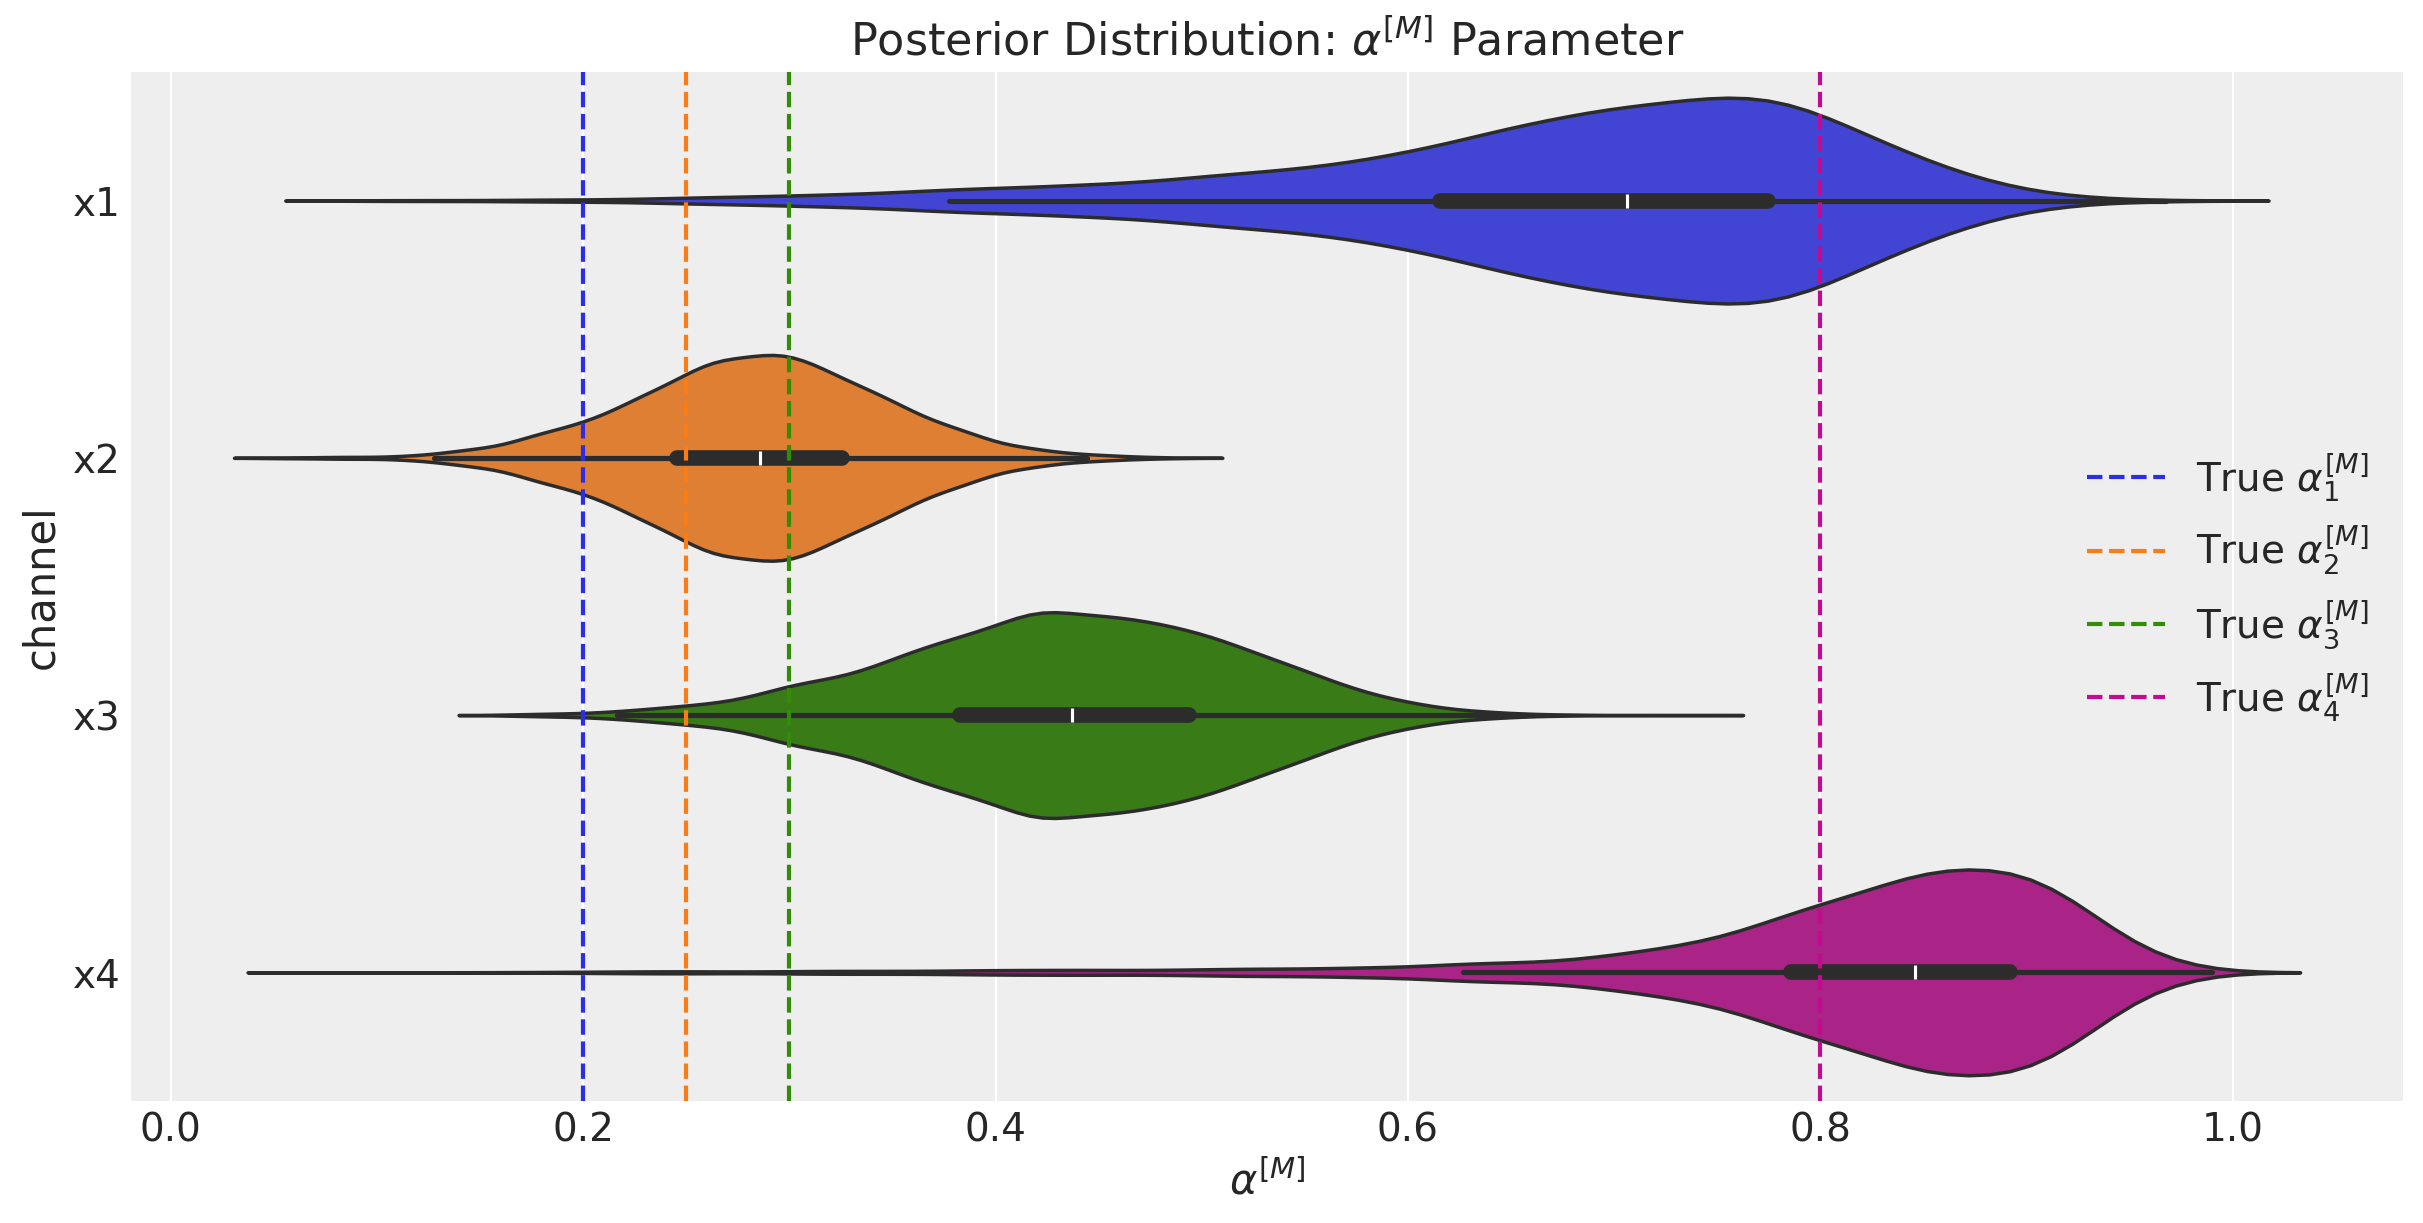

In [11]:
# True alphas
alpha1: float = 0.2
alpha2: float = 0.25
alpha3: float = 0.3
alpha4: float = 0.8

# Estimated alphas
alpha_m_samples_df = pd.DataFrame(data=az.extract(mmm.idata, var_names=['adstock_alpha']).T, columns = mmm.idata.posterior.channel)

fig, ax = plt.subplots(figsize = (12,6))
sns.violinplot(data=alpha_m_samples_df, orient="h", ax=ax)
ax.set(title=f"Posterior Distribution: {r"$\alpha^{[M]}$"} Parameter",xlabel=r"$\alpha^{[M]}$",ylabel="channel")
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"True $\alpha^{[M]}_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"True $\alpha^{[M]}_2$")
ax.axvline(x=alpha3, color="C2", linestyle="--", label=r"True $\alpha^{[M]}_3$")
ax.axvline(x=alpha4, color="C3", linestyle="--", label=r"True $\alpha^{[M]}_4$")
ax.legend()
plt.show()

Saturation Kappa

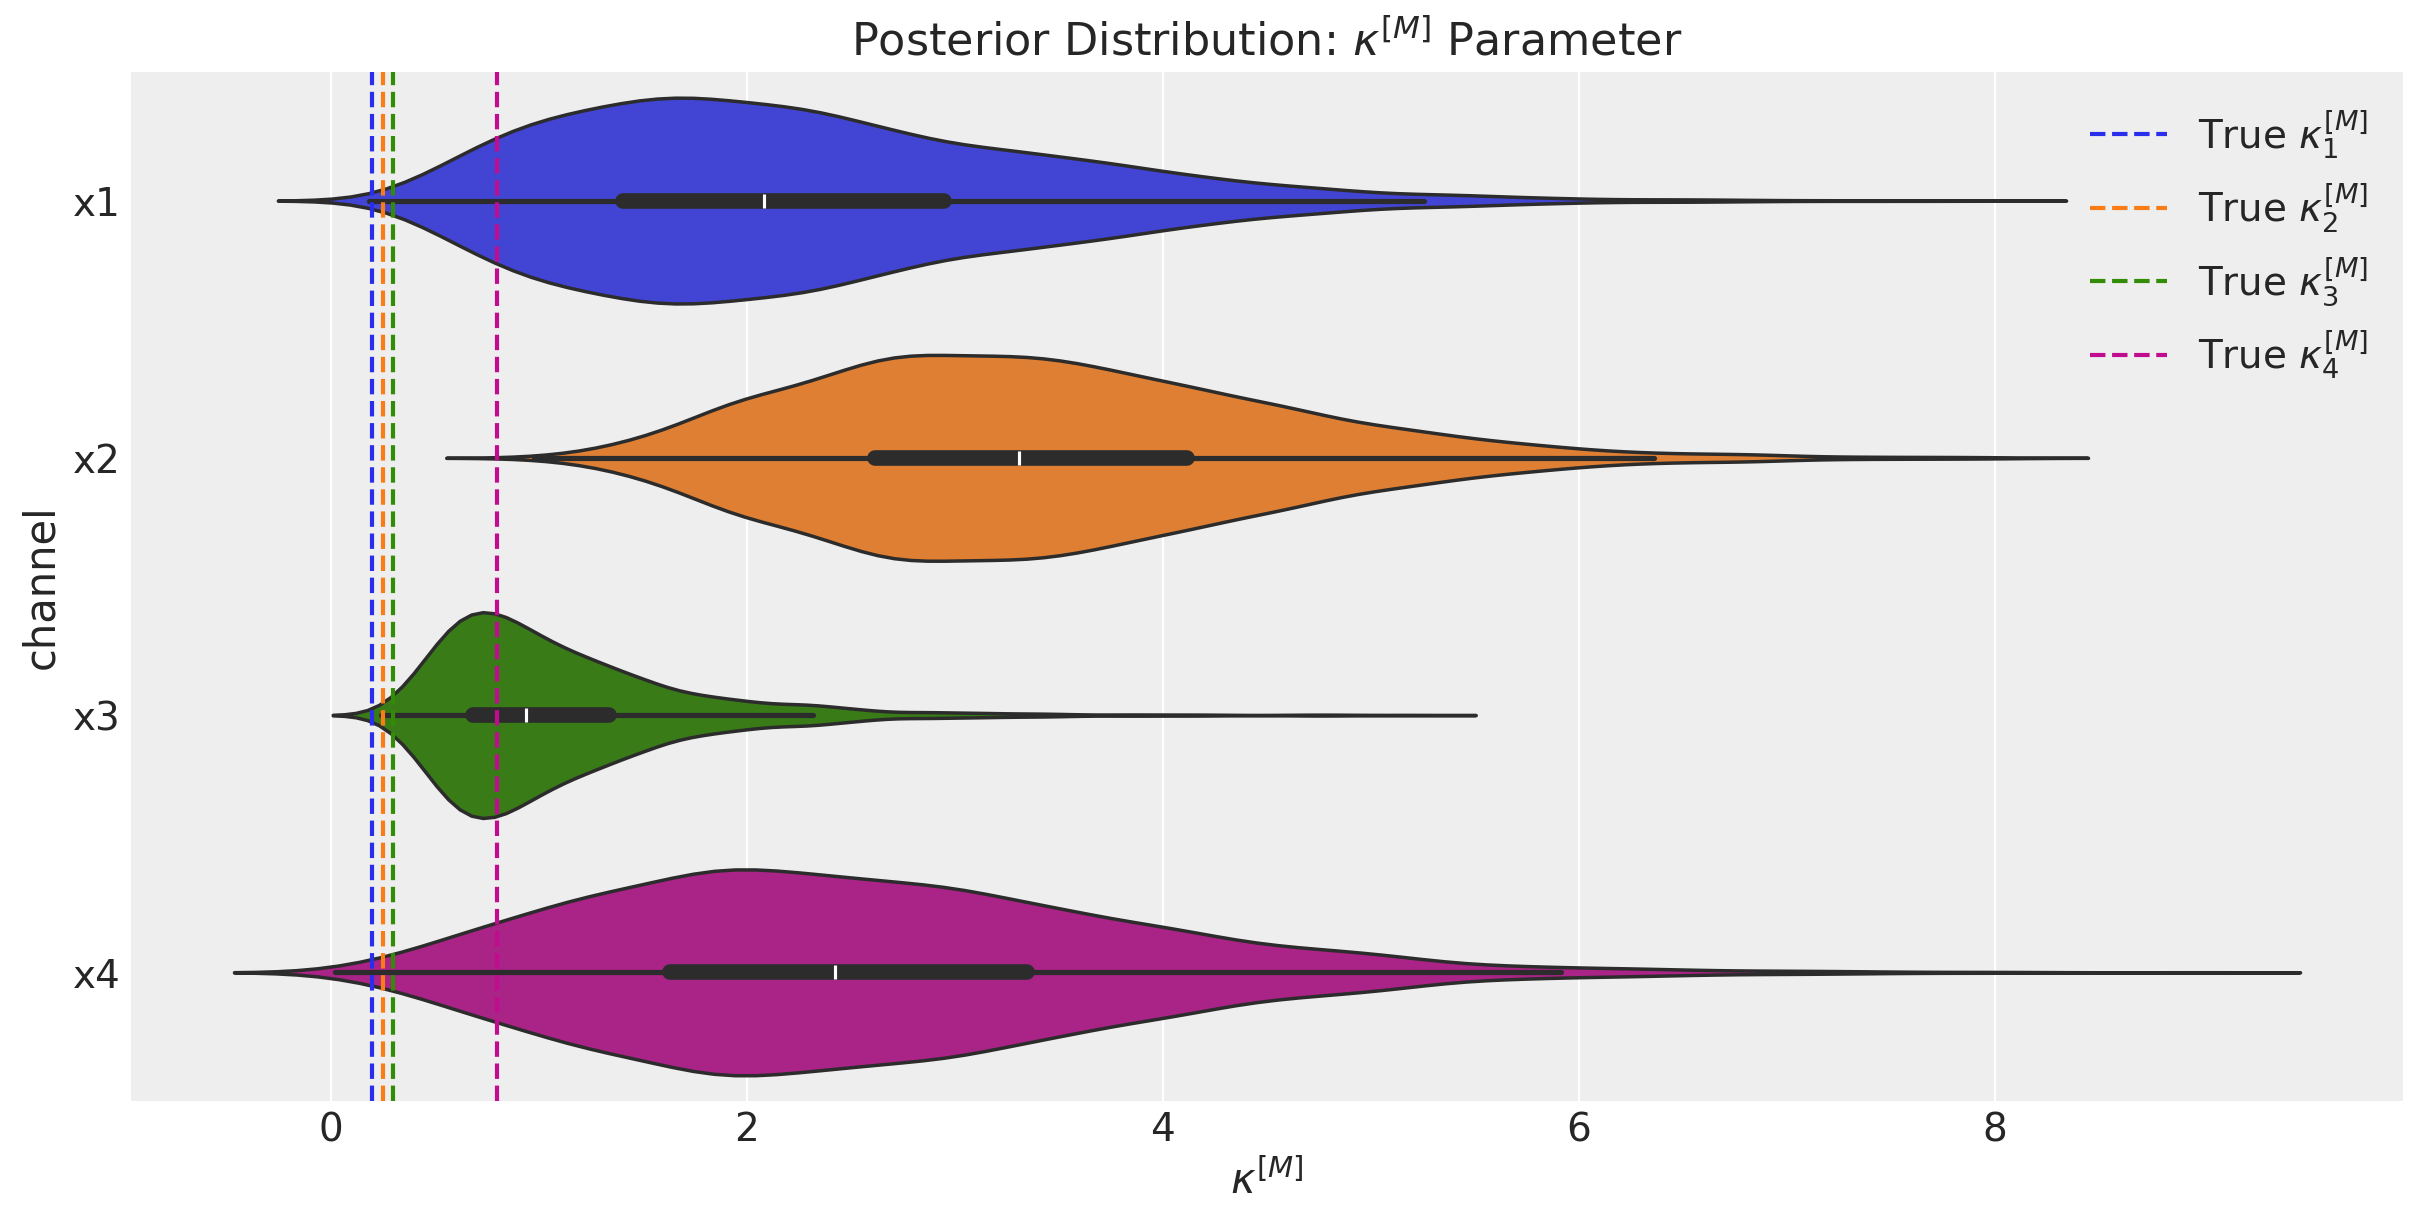

In [12]:
# True Kappas
kappa1: float = 0.6
kappa2: float = 0.75
kappa3: float = 0.7
kappa4: float = 0.8

# Estimated lambdas
lam_m_samples_df = pd.DataFrame(data=az.extract(mmm.idata, var_names=['saturation_kappa']).T, columns = mmm.idata.posterior.channel)

fig, ax = plt.subplots(figsize = (12,6))
sns.violinplot(data=lam_m_samples_df, orient="h", ax=ax)
ax.set(title=f"Posterior Distribution: {r"$\kappa^{[M]}$"} Parameter",xlabel=r"$\kappa^{[M]}$",ylabel="channel")
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"True $\kappa^{[M]}_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"True $\kappa^{[M]}_2$")
ax.axvline(x=alpha3, color="C2", linestyle="--", label=r"True $\kappa^{[M]}_3$")
ax.axvline(x=alpha4, color="C3", linestyle="--", label=r"True $\kappa^{[M]}_4$")
ax.legend()
plt.show()

### Insights recovery

- Contributions over time
- ROAS

**Note:** There is no functionality to extract the full sales attribution over time. You can extract channels and baseline, but to extract controls, you have to derive the contributions directly.

In [13]:
# Reading in true contributions
true_contributions = pd.read_csv("true_output_data.csv")

In [14]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
).reset_index()

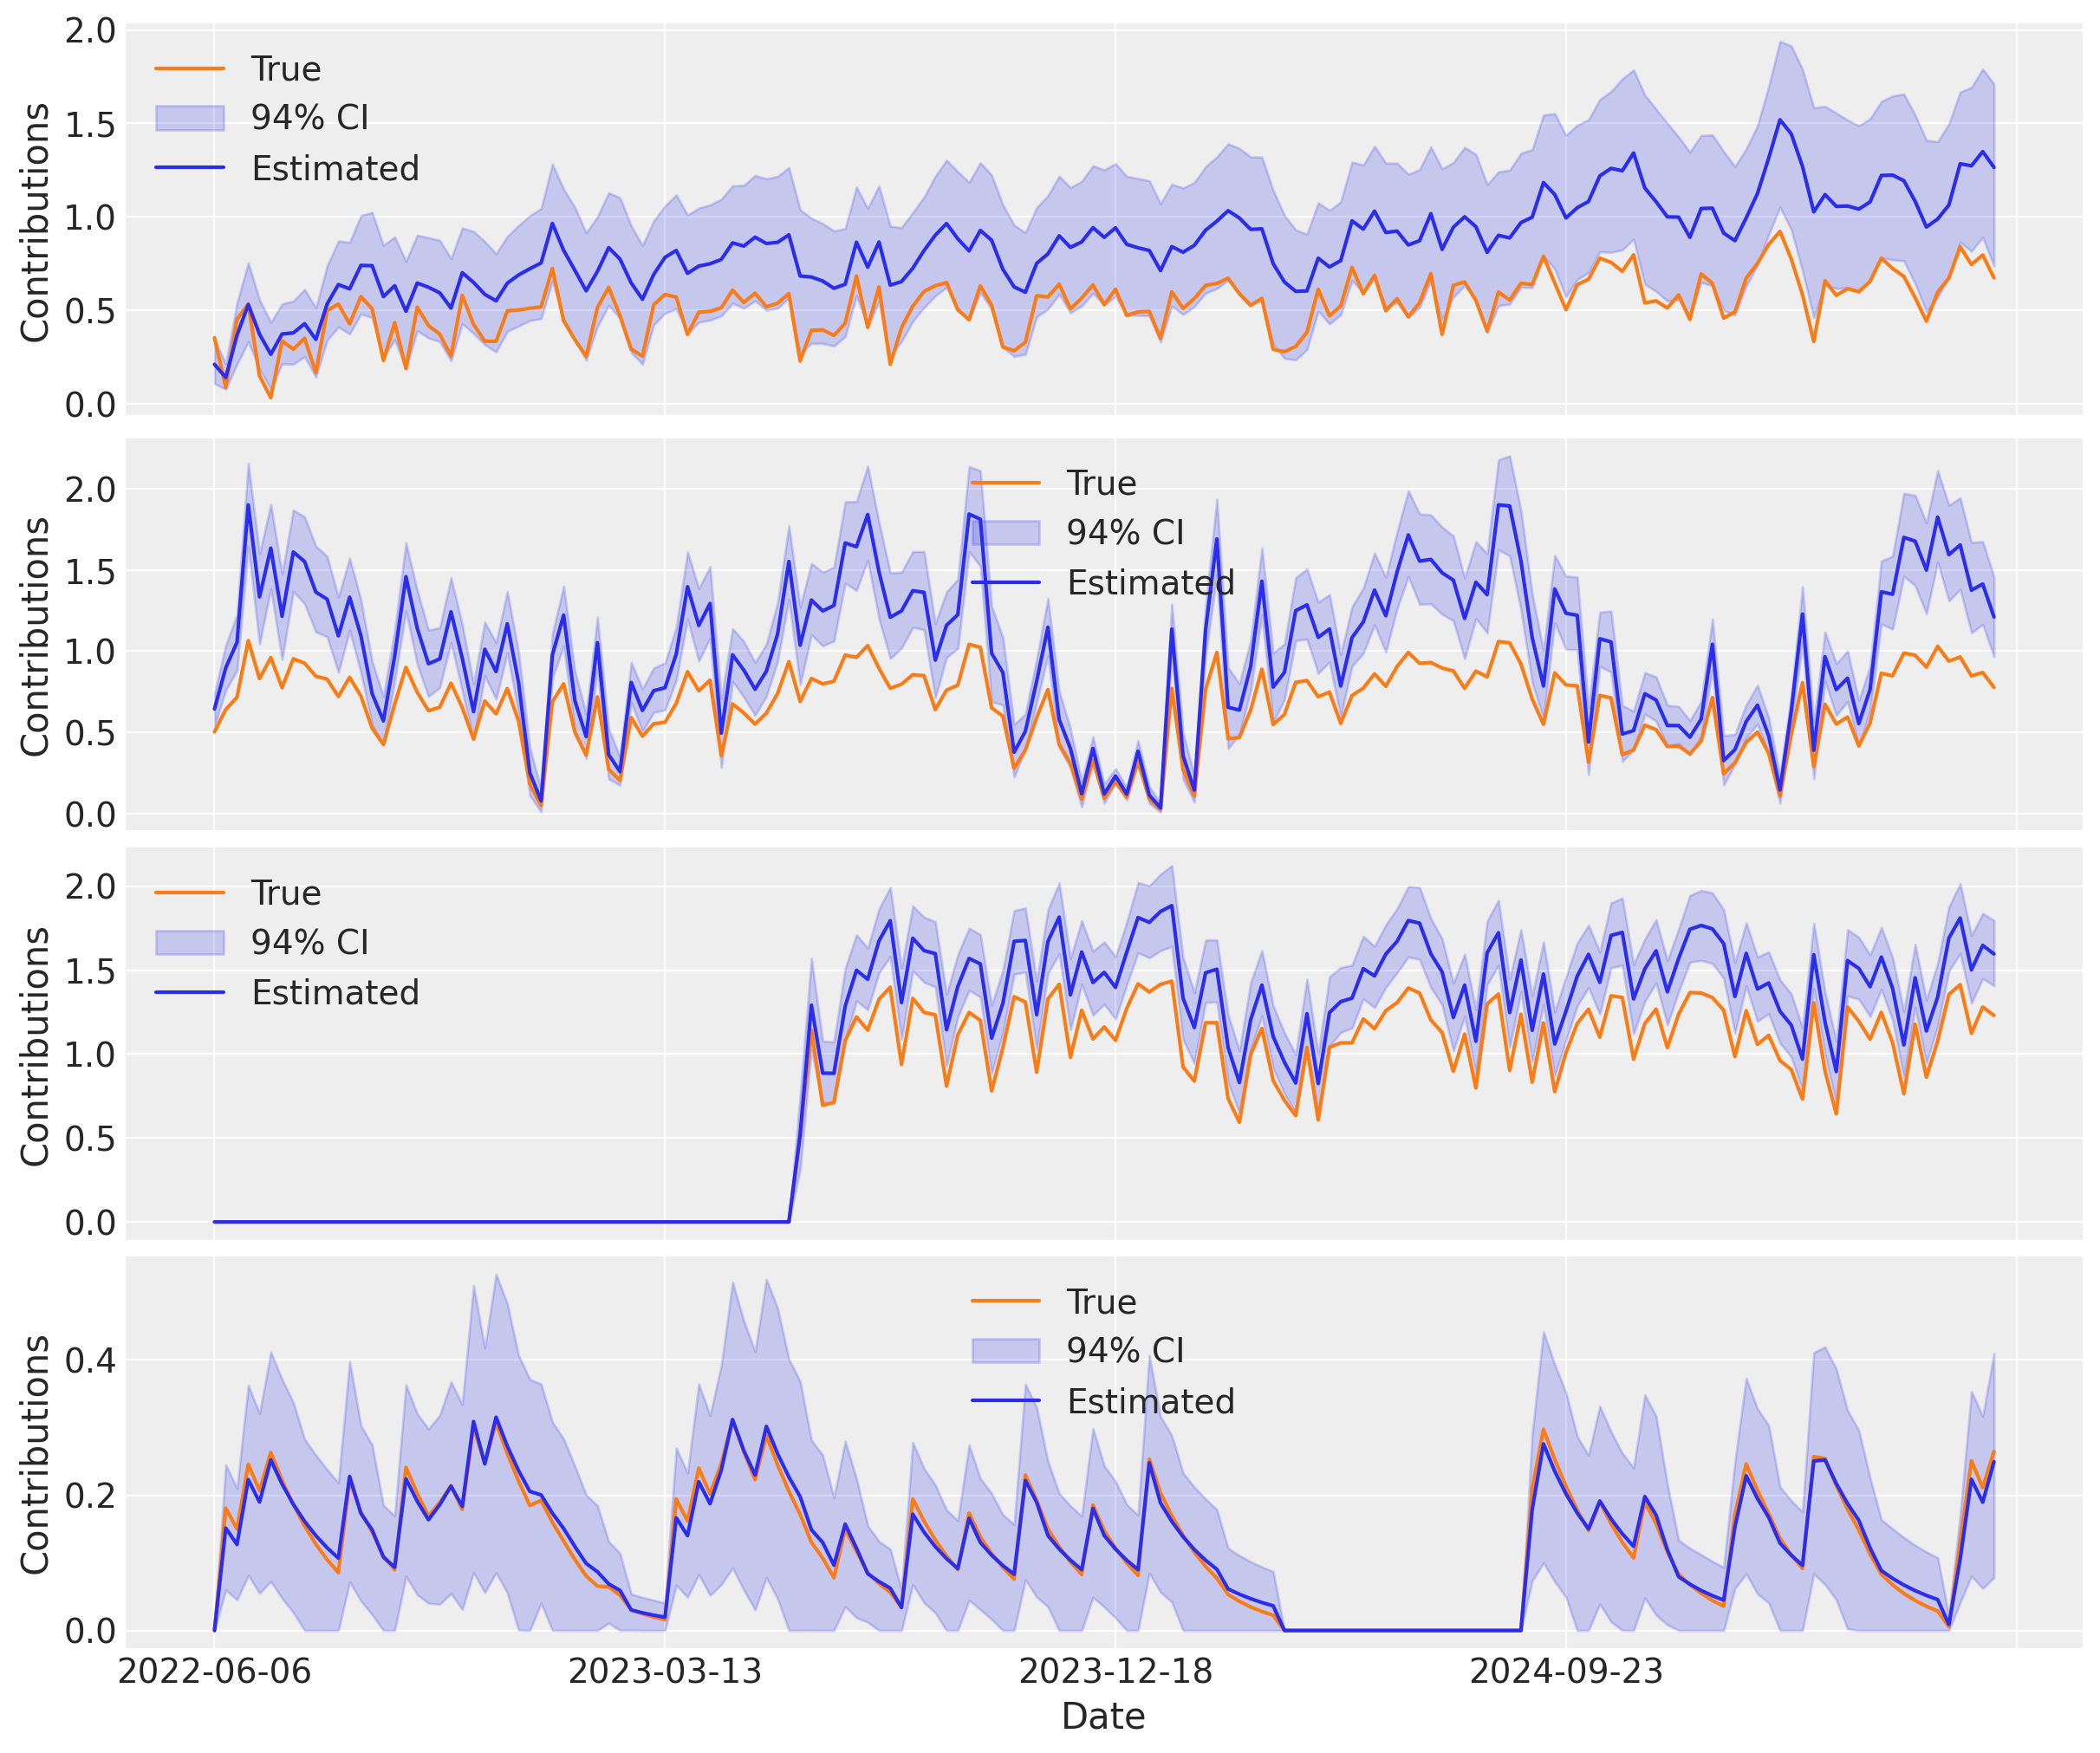

In [15]:
channels_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale
)

fig, ax = plt.subplots(
    nrows=4, figsize=(12, 10), ncols=1, sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2", "x3", "x4"]):
    # Estimate true contribution in the original scale from the data generating process
    sns.lineplot(
        x=true_contributions["date_week"],
        y=true_contributions[f"{x}"],
        color="C1",
        label="True",
        ax=ax[i],
    )
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=true_contributions["date_week"],
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        color="C0", alpha=0.2, label="94% CI"
    )
    # Mean estimated contribution in the original scale
    sns.lineplot(
        x=true_contributions["date_week"],
        y=get_mean_contributions_over_time_df[x].to_numpy(),
        color = "C0",
        label="Estimated",
        alpha=1,
        ax=ax[i],
    )
    ax[i].legend()
    ax[i].set(xlabel="Date", ylabel="Contributions")
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))

In [17]:
true_contributions_renamed = true_contributions

true_roas = true_contributions_renamed[["x1", "x2", "x3", "x4"]].sum()/data[["x1", "x2", "x3", "x4"]].sum()

In [18]:
estimated_roas = get_mean_contributions_over_time_df[['x1','x2','x3','x4']].sum()/data[["x1", "x2", "x3", "x4"]].sum()

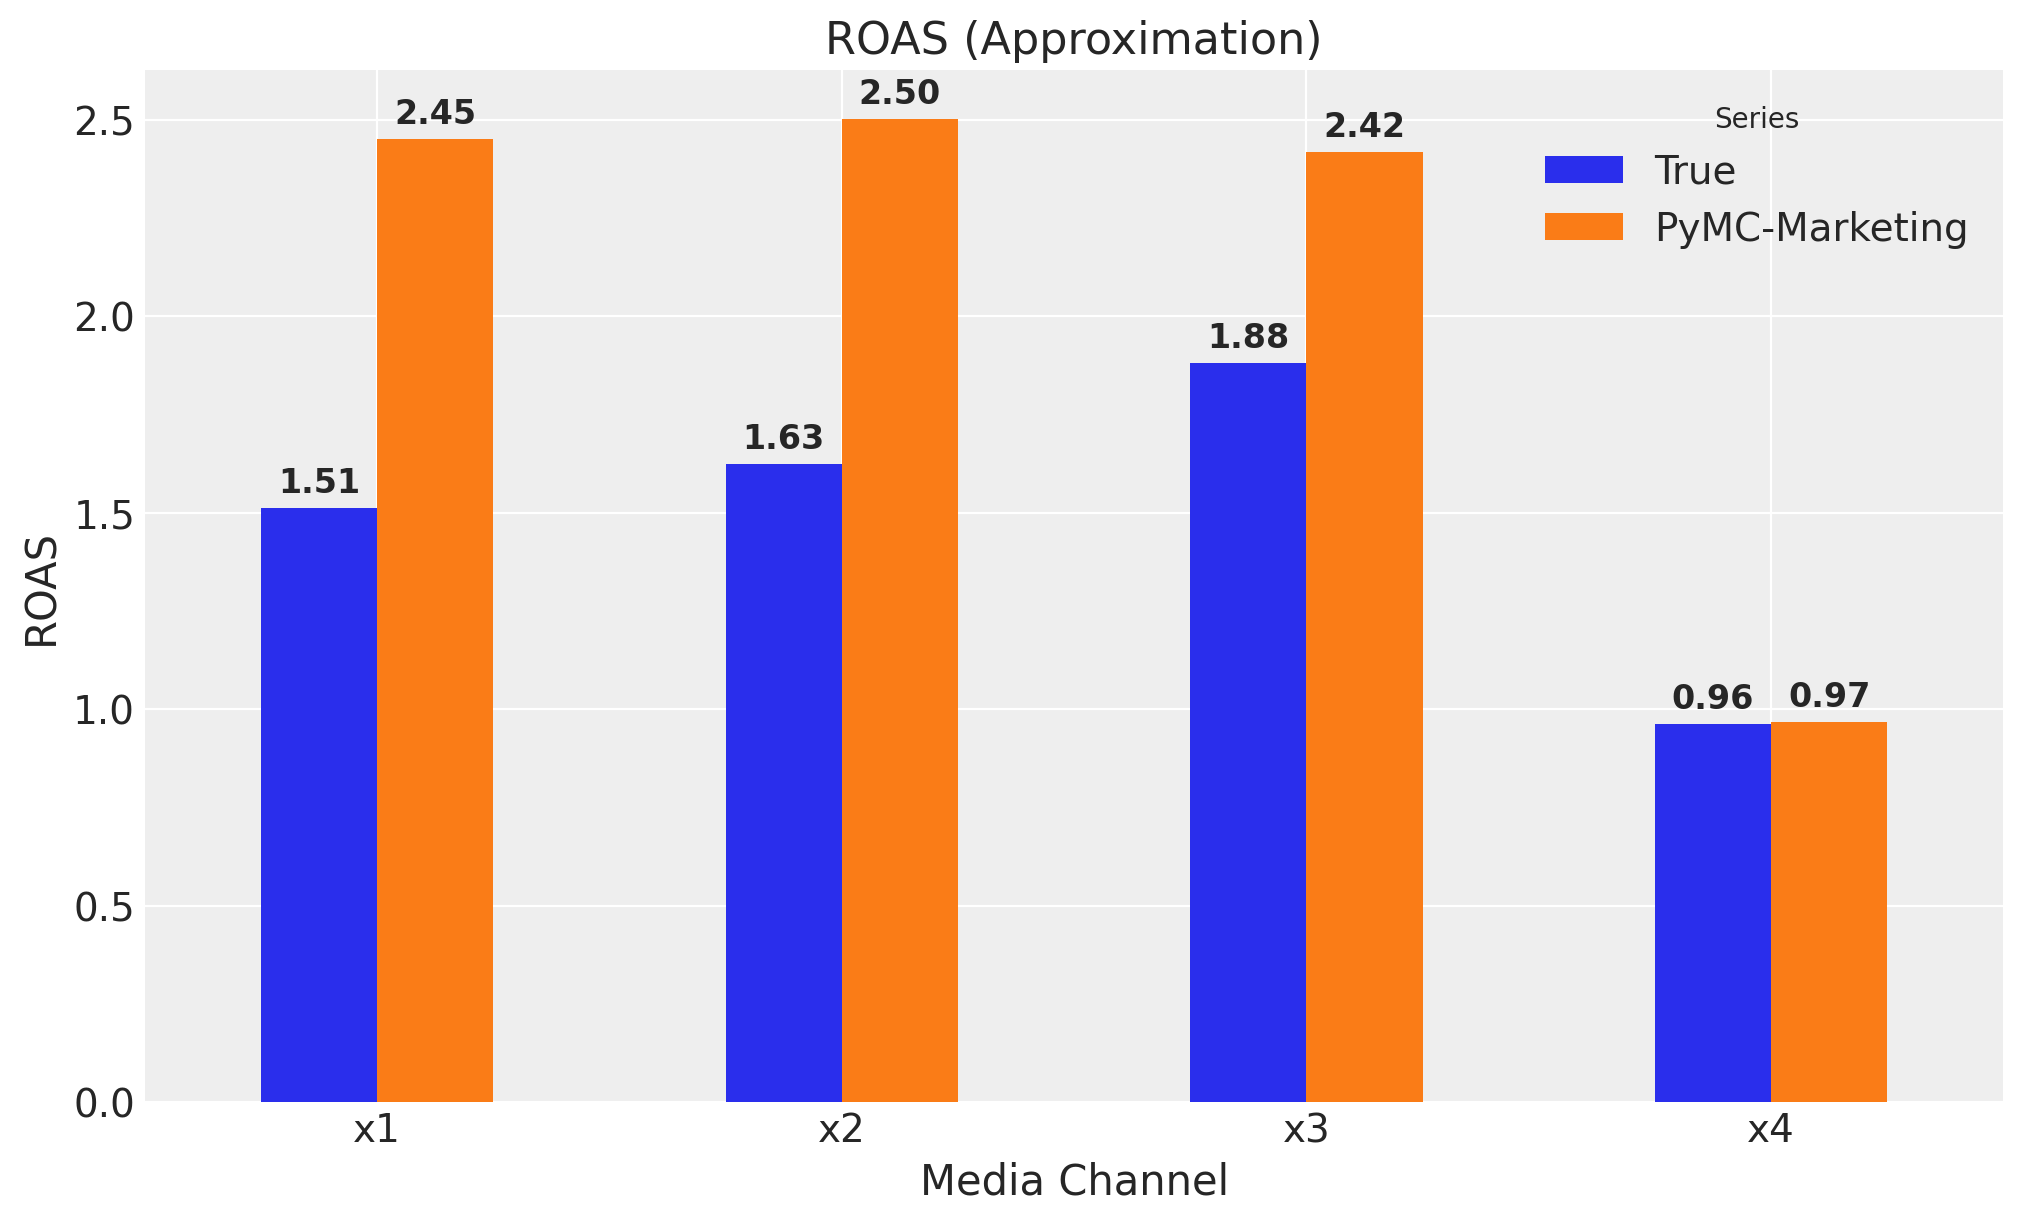

In [19]:
# Create DataFrame
roas = pd.DataFrame({"True": true_roas, "PyMC-Marketing": estimated_roas})

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bar chart
roas.plot(kind="bar", ax=ax, color=["C0", "C1"])

# Add title and labels
ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS")

# Add values above bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=12, fontweight="bold", padding=3)

# Show plot
plt.xticks(rotation=0)  # Ensure x-axis labels are readable
plt.legend(title="Series")
plt.show()